# Comparison of sequence generation in low- and high-inhibition regimes

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_color
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = {
    # E membrane dynamics
    'C_M_E': 1e-6, 'G_L_E': .1e-3, 'E_L_E': -0.05, 'V_TH_E': -0.036, 'V_R_E': -0.05, 'T_R_E': 0.002,
    # E architecture
    'N_E': 3000, 'N_X': 14, 'DX': .035,  # total E cells and chain params
    'W_E_E': .09e-3, 'W_MIN_E_E': .001e-4,  # recurrence
    'L_E_E_F': 0.03, 'L_E_E_B': 0.01,  # recurrence
    'W_E_A': .1e-3,  # adaptation (represented by inhibitory autapses)
    
    # I membrane dynamics
    'C_M_I': 1e-6, 'G_L_I': .2e-3, 'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    # I architecture
    'N_I': 750, 'P_I_E': .5, 'P_E_I': .5, 'W_I_E': 2e-6, 'W_E_I': 1.6e-6,  # interactions w E cells
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    'E_A': -0.1, 'T_A': 0.01,  # adaptation 
}

## SMLN
S = {
    'RNG_SEED': 100, 'DT': 0.0005, 'D_SMLN': .4,
    'TRG': {'T': 0.05, 'A': 10e-6, 'R': 0.15, 'D': 0.002, 'X': 0},
}

print('TAU_M_E = {:.1f} ms'.format(M['C_M_E']/M['G_L_E'] * 1e3))
print('TAU_M_I = {:.1f} ms'.format(M['C_M_I']/M['G_L_I'] * 1e3))

TAU_M_E = 10.0 ms
TAU_M_I = 5.0 ms


Chain position assignment and connectivity

In [2]:
# connectivity funcs
def assign_x(dx, n_x, n, randomize):
    
    # number of layers
    n_l = int(round(n/n_x))
    
    # cells per layer
    n_xs = np.array([len(_) for _ in np.array_split(np.arange(n), n_l)])

    # interleave layer counts to prevent heavier layers bunching at start
    idx_c = np.nan * np.zeros(n_l)

    for n_x_ in np.unique(n_xs):
        mask = n_xs == n_x_
        idx_c[mask] = np.linspace(0, 1, mask.sum()+2)[1:-1]
    n_xs = n_xs[np.argsort(idx_c)]

    # assign x positions
    x = cc([np.repeat(dx*x_ctr, n_xs[x_ctr]) for x_ctr in range(len(n_xs))])
    
    if randomize:
        x = x[np.random.permutation(n)]
        
    return x

def make_w_e_e(x, m):
    """Make E-E weight mat w/ weight increasing w/ proxim."""
    n_e = m['N_E']
    
    # build distance matrix
    dx = np.tile(x[:, None], (1, n_e)) - np.tile(x[None, :], (n_e, 1))
    
    # build weight matrix
    ## decrease weights as squared exp of dist
    w = np.nan * np.zeros(dx.shape)
    mask_f = dx >= 0  # forward cxns
    w[mask_f] = m['W_E_E'] * np.exp(-dx[mask_f]**2/(2*m['L_E_E_F']**2))
    mask_b = dx < 0  # bkwd cxns
    w[mask_b] = m['W_E_E'] * np.exp(-dx[mask_b]**2/(2*m['L_E_E_B']**2))
    ## set all weights below min weight th to 0
    w[w < m['W_MIN_E_E']] = 0
    
    return w

def make_w_i_e(m):
    """
    Make proximally biased E->I weight matrix.
    """
    n_i = m['N_I']
    n_e = m['N_E']
    
    # build weight matrix
    w_i_e = m['W_I_E'] * (np.random.rand(n_i, n_e) < m['P_I_E']).astype(float)
    return w_i_e
    
def make_w_e_i(m):
    """
    Make center-surround structured I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < m['P_E_I']).astype(float)
    return w_e_i


def build_ntwk(m, s):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s['RNG_SEED'])
    
    # set membrane properties
    n = m['N_E'] + m['N_I']
    
    c_m = cc(
        [np.repeat(m['C_M_E'], m['N_E']), np.repeat(m['C_M_I'], m['N_I'])])
    g_l = cc(
        [np.repeat(m['G_L_E'], m['N_E']), np.repeat(m['G_L_I'], m['N_I'])])
    e_l = cc(
        [np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])
    v_th = cc(
        [np.repeat(m['V_TH_E'], m['N_E']), np.repeat(m['V_TH_I'], m['N_I'])])
    v_r = cc(
        [np.repeat(m['V_R_E'], m['N_E']), np.repeat(m['V_R_I'], m['N_I'])])
    t_r = cc(
        [np.repeat(m['T_R_E'], m['N_E']), np.repeat(m['T_R_I'], m['N_I'])])
    
    # assign chain positions (x) to E cells
    x_e = assign_x(m['DX'], m['N_X'], m['N_E'], randomize=True)
    x = cc([x_e, np.zeros(m['N_I'])])
    
    w_u = {'E': np.zeros((m['N_E'] + m['N_I'], 0))}  # no upstream spike inputs
    
    # make rcr ws
    targs_r = cc([np.repeat('E', m['N_E']), np.repeat('I', m['N_I'])])
    
    w_e_e = make_w_e_e(x[:m['N_E']], m)
    w_i_e = make_w_i_e(m)
    w_e_i = make_w_e_i(m)
    
    w_e_a = m['W_E_A'] * np.eye(m['N_E'])
    
    w_r_temp = {
        'E': {('E', 'E'): w_e_e, ('I', 'E'): w_i_e},
        'I': {('E', 'I'): w_e_i},
        'A': {('E', 'E'): w_e_a},
    }
    
    w_r = join_w(targs_r, targs_r, w_r_temp)
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m,
        g_l=g_l,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_r,
        e_s={'E': m['E_E'], 'I': m['E_I'], 'A': m['E_A']},
        t_s={'E': m['T_E'], 'I': m['T_I'], 'A': m['T_A']},
        w_r=w_r,
        w_u=w_u)
    
    ntwk.x = x
    
    ntwk.types_r = targs_r
    
    ntwk.n_e = m['N_E']
    ntwk.n_i = m['N_I']
    ntwk.n = m['N_E'] + m['N_I']
    
    return ntwk


def i_ext_trg(t, ntwk, m, s):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # get mask over cells to trigger to induce replay
    ## compute distances to trigger center
    dx = ntwk.x - s['TRG']['X']

    ## get mask
    trg_mask = (np.abs(dx) < s['TRG']['R']) & (ntwk.types_r == 'E')

    ## get time mask
    t_mask = (s['TRG']['T'] <= t) \
        & (t < (s['TRG']['T'] + s['TRG']['D']))

    ## add in external trigger
    i_ext[np.outer(t_mask, trg_mask)] = s['TRG']['A']

    return i_ext

# Simulations

In [3]:
# weak inhibition
m_0 = copy(M)

m_0['W_E_E'] = .055e-3
m_0['W_E_A'] = .0575e-3
m_0['W_E_I'] = .2e-6

ntwk_0 = build_ntwk(m_0, S)

# strong inhibition
m_1 = copy(M)

m_1['W_E_E'] = .1e-3
m_1['W_E_A'] = .1e-3
m_1['W_E_I'] = 2e-6

ntwk_1 = build_ntwk(m_1, S)

t = np.arange(0, S['D_SMLN'], S['DT'])

# initialize external current array
i_ext = np.zeros((len(t), M['N_E'] + M['N_I']))

# add replay trigger
i_ext += i_ext_trg(t, ntwk_0, M, S)

clamp = Generic(
    v={0: cc([np.repeat(M['E_L_E'], M['N_E']), np.repeat(M['E_L_I'], M['N_I'])])}, spk={})

In [4]:
# loop over noise levels
noise_std = np.linspace(0, 4e-6, 17)

rslts_0 = []
rslts_1 = []

for noise_std_ in noise_std:
    print('Running smln w/ noise std {} uA...'.format(noise_std_ * 1e6))
    i_ext_noise = i_ext.copy()
    i_ext_noise += noise_std_*np.random.randn(*i_ext.shape)
    
    # run smlns
    rslt_0 = ntwk_0.run(i_ext=i_ext_noise, clamp=clamp, dt=S['DT'])
    rslt_0.ntwk = ntwk_0
    rslts_0.append(copy(rslt_0))
    
    rslt_1 = ntwk_1.run(i_ext=i_ext_noise, clamp=clamp, dt=S['DT'])
    rslt_1.ntwk = ntwk_1
    rslts_1.append(copy(rslt_1))
    
print('Done')

Running smln w/ noise std 0.0 uA...
Running smln w/ noise std 0.25 uA...
Running smln w/ noise std 0.5 uA...
Running smln w/ noise std 0.75 uA...
Running smln w/ noise std 1.0 uA...
Running smln w/ noise std 1.25 uA...
Running smln w/ noise std 1.5 uA...
Running smln w/ noise std 1.75 uA...
Running smln w/ noise std 2.0 uA...
Running smln w/ noise std 2.25 uA...
Running smln w/ noise std 2.5 uA...
Running smln w/ noise std 2.75 uA...
Running smln w/ noise std 3.0 uA...
Running smln w/ noise std 3.25 uA...
Running smln w/ noise std 3.5 uA...
Running smln w/ noise std 3.7499999999999996 uA...
Running smln w/ noise std 4.0 uA...
Done


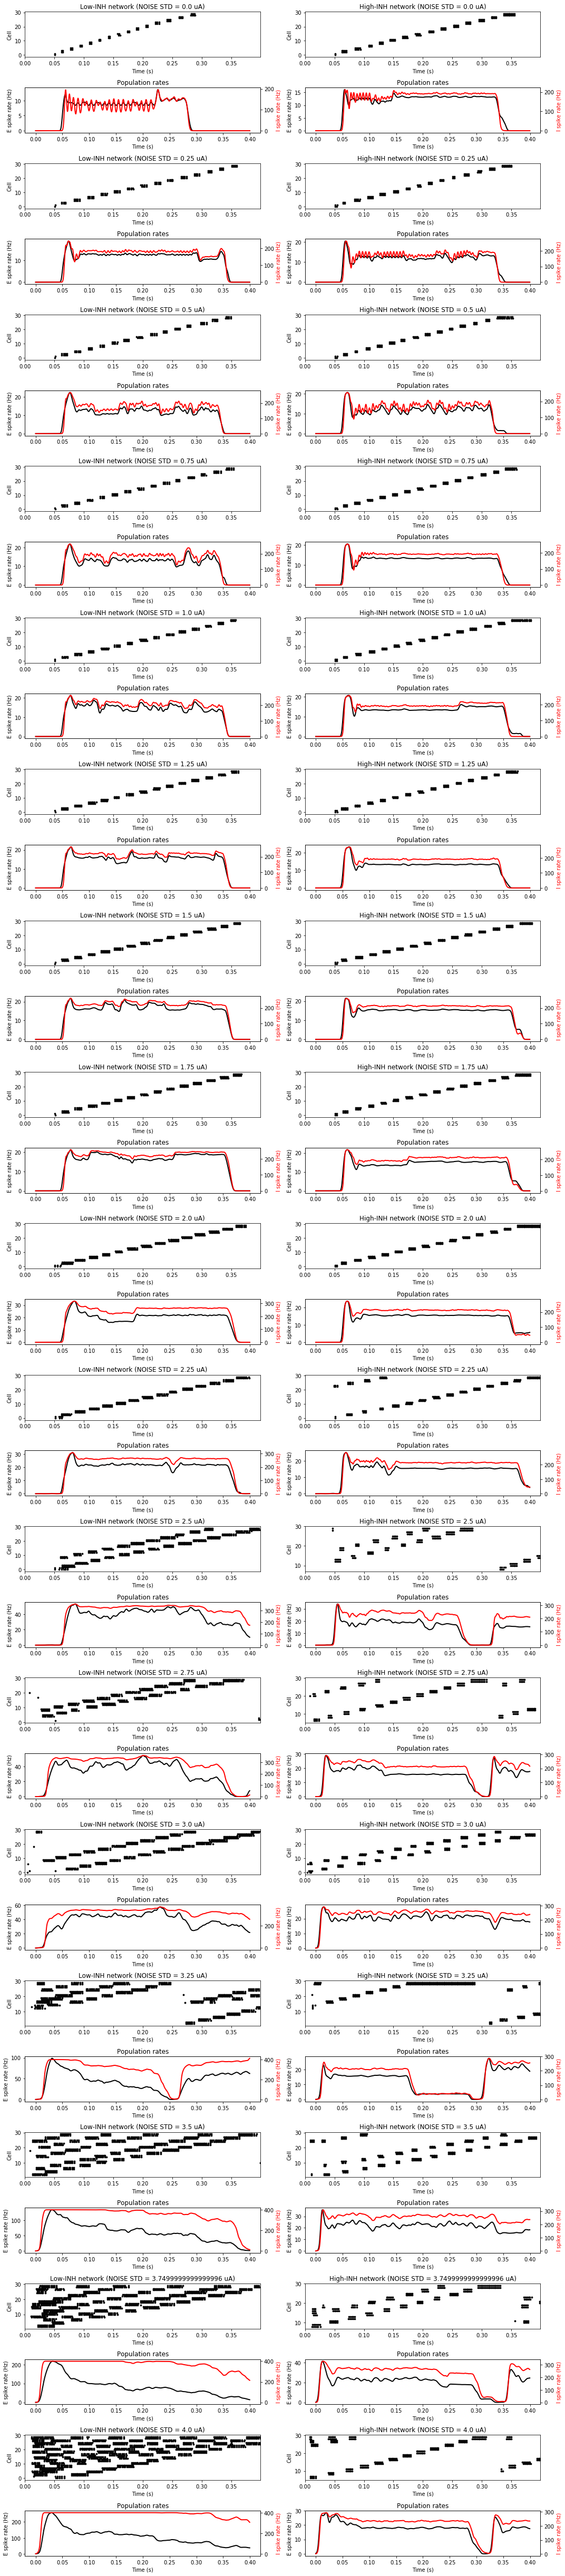

In [5]:
# make plots
EPOCH = (t[0], t[-1])
NEAREST = 2
C = 'k'
CMAP = 'inferno'
SMOOTHNESS = 4

fig, axs = plt.subplots(2*len(noise_std), 2, figsize=(15, 4*len(noise_std)), tight_layout=True)

# plot funcs
def get_idxs_nearest(x_seq, x, nearest):
    """
    Get ordered idxs of place fields nearest to a sequence of xs.
    """
    idxs = []
    
    for x_ in x_seq:
        # get dists of all xs in x_seq to x
        dx = x - x_
        
        # add idxs of closest neurons to list
        idxs_ = list(np.abs(dx).argsort()[:nearest])
        idxs.extend(idxs_)
        
    return idxs


for ctr, (rslt_0, rslt_1, noise_std_) in enumerate(zip(rslts_0, rslts_1, noise_std)):
    
    # sequence raster    
    ax_00 = axs[2*ctr, 0]
    ax_01 = axs[2*ctr, 1]
    
    # low-inhibition
    x_raster = np.linspace(0, rslt_0.ntwk.x.max(), 15)
    x = rslt_0.ntwk.x[rslt_0.ntwk.types_r == 'E']

    spks_e_chosen = rslt_0.spks[:, get_idxs_nearest(x_raster, x, NEAREST)]

    t_mask = (EPOCH[0] <= rslt_0.t) & (rslt_0.t < EPOCH[1])
    t_start = rslt_0.t[t_mask][0]

    spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * S['DT'] + t_start
    
    ax_00.scatter(spk_ts, es, c=C, s=8, vmin=0, vmax=1, cmap=CMAP)
    ax_00.set_title('Low-INH network (NOISE STD = {} uA)'.format(noise_std_ * 1e6))
    
    # high-inhibition
    x_raster = np.linspace(0, rslt_1.ntwk.x.max(), 15)
    x = rslt_1.ntwk.x[rslt_1.ntwk.types_r == 'E']

    spks_e_chosen = rslt_1.spks[:, get_idxs_nearest(x_raster, x, NEAREST)]

    t_mask = (EPOCH[0] <= rslt_1.t) & (rslt_1.t < EPOCH[1])
    t_start = rslt_1.t[t_mask][0]

    spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * S['DT'] + t_start

    ax_01.scatter(spk_ts, es, c=C, s=8, vmin=0, vmax=1, cmap=CMAP)
    ax_01.set_title('High-INH network (NOISE STD = {} uA)'.format(noise_std_ * 1e6))
    
    for ax in [ax_00, ax_01]:
        ax.set_xlim(0, rslt_0.t[-1])
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Cell')
        
    # ppln firing rates
    ax_10 = axs[2*ctr+1, 0]
    ax_11 = axs[2*ctr+1, 1]
    
    spks_e = rslt_0.spks[:, :M['N_E']]
    ax_10.plot(rslt_0.t, smooth(spks_e.sum(axis=1) / (rslt_0.dt * M['N_E']), SMOOTHNESS), c='k', lw=2)
    
    spks_i = rslt_0.spks[:, -M['N_I']:]
    ax_twin = ax_10.twinx()
    ax_twin.plot(rslt_0.t, smooth(spks_i.sum(axis=1) / (rslt_0.dt * M['N_I']), SMOOTHNESS), c='r', lw=2)
    ax_twin.set_ylabel('I spike rate (Hz)', color='r')
    
    spks_e = rslt_1.spks[:, :M['N_E']]
    ax_11.plot(rslt_1.t, smooth(spks_e.sum(axis=1) / (rslt_1.dt * M['N_E']), SMOOTHNESS), c='k', lw=2)
    
    spks_i = rslt_1.spks[:, -M['N_I']:]
    ax_twin = ax_11.twinx()
    ax_twin.plot(rslt_1.t, smooth(spks_i.sum(axis=1) / (rslt_1.dt * M['N_I']), SMOOTHNESS), c='r', lw=2)
    ax_twin.set_ylabel('I spike rate (Hz)', color='r')
    
    for ax in [ax_10, ax_11]:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('E spike rate (Hz)')
        ax.set_title('Population rates')